In [1]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

import tensorflow as tf
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import numpy as np
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
def layer1(input_, filters=64):
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(input_)
    bn1 = BatchNormalization()(c1)
    actRelu = relu(bn1)
    
    return actRelu

def layer2(input_, filters=64):
    l1 = layer1(input_)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    conc = concatenate([bn1, input_])
    
    return conc

def layer3(input_, filters=64):
    l1 = layer1(input_)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    mp1 = MaxPool2D(pool_size=(2,2), strides=(2, 2))(bn1)
    
    # side stream
    c1_s = Conv2D(filters=filters, kernel_size=(1,1), strides=(2, 2), activation='relu', padding='same')(input_)
    bn1_s = BatchNormalization()(c1_s)
    
    conc = concatenate([mp1, bn1_s])
    
    return conc

def layer4(input_, filters=64):
    l1 = layer1(input_)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    g1 = GlobalAveragePooling2D()(bn1)
    
    return g1

In [8]:
def srnet(input_img):
    # Two layers of type 1
    l1_1 = layer1(input_img, filters=64)
    l1_2 = layer1(l1_1, filters=16)
    
#     # Five layers of type 2
    l2_1 = layer2(l1_2, filters=16)
    l2_2 = layer2(l2_1, filters=16)
    l2_3 = layer2(l2_2, filters=16)
    l2_4 = layer2(l2_3, filters=16)
    l2_5 = layer2(l2_4, filters=16)
    
    l3_1 = layer3(l2_5, filters=16)
    l3_2 = layer3(l3_1, filters=64)
    
    l4_1 = layer4(l3_2, filters=16)
    
    fc1 = Flatten()(l4_1)
    d1 = Dense(512)(fc1)
    
#     a1 = softmax(d1)
    
    return d1

In [11]:
image_size = (32, 32)
input_img = Input(shape = (*image_size, 3))

model_BGR =  Sequential(Model(input_img, srnet(input_img)))


model_HSV = Sequential(Model(input_img, srnet(input_img)))
# model_HSV.add(Flatten())


# # model_YUV = Model(input_img, model(input_img))
model_YUV = Sequential(Model(input_img, srnet(input_img)))
# model_YUV.add(Flatten())

# # model_LAB = Model(input_img, model(input_img))
model_LAB = Sequential(Model(input_img, srnet(input_img)))
# model_LAB.add(Flatten())

model_HED = Sequential(Model(input_img, srnet(input_img)))
# model_HED.add(Flatten())

model_XYZ = Sequential(Model(input_img, srnet(input_img)))
# model_XYZ.add(Flatten())

In [12]:
x = concatenate(inputs=[model_BGR.output, model_HSV.output, model_YUV.output,
                       model_LAB.output, model_HED.output, model_XYZ.output])

In [13]:
z = Dense(2, activation="softmax")(x)
# our model will accept the inputs of the two branches and
# then output a single value
model_comb = Model(inputs=[model_BGR.input, model_HSV.input, model_YUV.input, 
                          model_LAB.input, model_HED.input, model_XYZ.input], outputs=z)

In [14]:
model_comb.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_1_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_2_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_3_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_4_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
____________________________________________________________________________________________

In [99]:
limit = 250
cover_imgs = glob.glob('../Cover/*.jpg')
cover_imgs = cover_imgs[:limit]

jmipod_imgs = glob.glob('../JMiPOD/*.jpg')
jmipod_imgs = jmipod_imgs[:limit]

juniward_imgs = glob.glob('../JUNIWARD/*.jpg')
juniward_imgs = juniward_imgs[:limit]

uerd_imgs = glob.glob('../UERD/*.jpg')
uerd_imgs = uerd_imgs[:limit]

In [100]:
print(cover_imgs[0])
print(jmipod_imgs[0])
print(juniward_imgs[0])
print(uerd_imgs[0])

../Cover/34055.jpg
../JMiPOD/34055.jpg
../JUNIWARD/34055.jpg
../UERD/34055.jpg


In [101]:
list_IDs = cover_imgs + jmipod_imgs + juniward_imgs + uerd_imgs

In [102]:
random.Random(4).shuffle(list_IDs)

train_IDs = list_IDs[:750]
test_IDs = list_IDs[750:]

In [103]:
len(train_IDs)

750

In [104]:
def get_image_data(image_id, image_size):
    img = cv2.imread(image_id)
    h, w = image_size
    crop_img = img[0:h, 0:w]
    return crop_img/255.

def get_label(image_id):
    if 'Cover' in image_id:
        return [1,0,0,0]
    elif 'JMiPOD' in image_id:
        return [0,1,0,0]
    elif 'JUNIWARD' in image_id:
        return [0,0,1,0]
    elif 'UERD' in image_id:
        return [0,0,0,1]

In [105]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1, 
                 shuffle=True, number_of_labels=4):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.number_of_labels = number_of_labels
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        # cv2 recevrses height and width
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim[::-1], self.n_channels))
#         y = np.empty((self.batch_size, *self.dim[::-1]))
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.number_of_labels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = get_image_data(ID, self.dim)
            y[i,:] = get_label(ID)
            
        
        return X, y

In [106]:
image_size = (256, 256)
# Parameters
params = {'dim': image_size,
          'batch_size': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(test_IDs, **params)

In [107]:
X, y = training_generator.__getitem__(3)

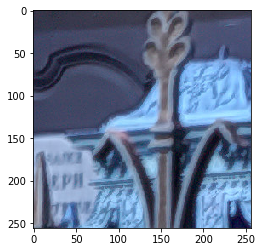

In [108]:
plt.imshow(X[0])

In [109]:
sr_.compile(loss=keras.losses.binary_crossentropy, 
                    metrics=['accuracy'], optimizer='adadelta')

In [110]:
sr_model_history = sr_.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=5)

W0502 18:35:20.829139 140142739007296 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0502 18:35:20.885732 140142739007296 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 375 steps, validate for 125 steps
Epoch 1/5
 19/375 [>.............................] - ETA: 30:26 - loss: 0.5494 - accuracy: 0.7500

KeyboardInterrupt: 

In [ ]:
def layer1(input_, filters=64):
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same', activation'relu')(input_)
    bn1 = BatchNormalization()(c1)
    actRelu = relu(bn1)
    
    return actRelu

def layer2(input_, filters=64):
    l1 = layer1(input_, filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same', activation'relu')(l1)
    bn1 = BatchNormalization()(c1)
    actRelu = relu(bn1)
    conc = concatenate([actRelu, input_])
    
    return conc

def layer3(input_, filters=64):
    l1 = layer1(input_, filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same', activation'relu')(l1)
    bn1 = BatchNormalization()(c1)
    actRelu = relu(bn1)
    mp1 = AveragePooling2D(pool_size=(2,2), strides=(2, 2))(actRelu)
    
    # side stream
    c1_s = Conv2D(filters=filters, kernel_size=(3,3), strides=(2, 2), padding='same', activation'relu'ut_)
    bn1_s = BatchNormalization()(c1_s)
    
    conc = concatenate([mp1, bn1_s])
    
    return conc

def layer4(input_, filters=64):
    l1 = layer1(input_, filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same', activation'relu')(l1)
    bn1 = BatchNormalization()(c1)
    actRelu = relu(bn1)
    g1 = GlobalAveragePooling2D()(actRelu)
    
    return g1